In [1]:
import requests
from owslib.wcs import WebCoverageService
import rasterio
import matplotlib.pyplot as plt
from pyproj import Proj, transform
import overpass
import geojson
import pandas as pd
import geopandas as gpd
import numpy as np

In [5]:
import warnings
warnings.simplefilter("ignore")

# Download DEM
from WCS service (source https://tinitaly.pi.ingv.it/wcs_service.html)

In [2]:
# URL of the WCS service capabilities
wcs_getCapabilities_url = 'http://tinitaly.pi.ingv.it/TINItaly_1_1/wcs?service=WCS&request=getCapabilities'

# Connect to the WCS
wcs = WebCoverageService(wcs_getCapabilities_url, version='1.0.0')

In [3]:
# List available contents
wcs.contents

{'TINItaly_1_1:tinitaly_dem': <owslib.coverage.wcs100.ContentMetadata at 0x11f3cb0a0>,
 'TINItaly_1_1:tinitaly_hsv': <owslib.coverage.wcs100.ContentMetadata at 0x11f3cb100>,
 'TINItaly_1_1:tinitaly_hshd': <owslib.coverage.wcs100.ContentMetadata at 0x11f3cb1c0>,
 'TINItaly_1_1:tinitaly_od': <owslib.coverage.wcs100.ContentMetadata at 0x11f3cb1f0>,
 'TINItaly_1_1:tinitaly_svf_2d5': <owslib.coverage.wcs100.ContentMetadata at 0x11f3cb220>,
 'TINItaly_1_1:tinitaly_svf_ea': <owslib.coverage.wcs100.ContentMetadata at 0x11f3cb250>,
 'TINItaly_1_1:tinitaly_slope': <owslib.coverage.wcs100.ContentMetadata at 0x11f3cb280>,
 'TINItaly_1_1:tinitaly_slope_2d5': <owslib.coverage.wcs100.ContentMetadata at 0x11f3cb2b0>}

In [6]:
## Prep for request
# Define the bounding box in geographic coordinates (lon, lat) 
bbox_geo = (9.899299,44.166271,10.601051,44.527670) # APP TOSCO-EMILIANO
# Example of other areas
#bbox_geo = (10.460163,46.019740,11.083637,46.343023) # ADAMELLO/BRENTA
#bbox_geo = (12.915876,42.697568,13.496778,43.122027) # SIBILLINI

# Define the source and destination CRS
src_crs = Proj(init='epsg:4326')  # WGS84 (deg)
dst_crs = Proj(init='epsg:32632')  # UTM zone 32N (meters)

# Transform the bounding box coordinates to UTM
xmin, ymin = transform(src_crs, dst_crs, bbox_geo[0], bbox_geo[1])
xmax, ymax = transform(src_crs, dst_crs, bbox_geo[2], bbox_geo[3])

bbox_utm = (xmin, ymin, xmax, ymax)

print(f"Transformed bounding box in UTM: {bbox_utm}")

# Desired resolution (meters)
desired_resolution = 10

# Calculate width and height in pixels
width = int((xmax - xmin) / desired_resolution)
height = int((ymax - ymin) / desired_resolution)

print(f"Width in pixels: {width}, Height in pixels: {height}")

Transformed bounding box in UTM: (571898.9306857754, 4890733.6200815, 627220.0394198465, 4931729.341482854)
Width in pixels: 5532, Height in pixels: 4099


In [7]:
# Perform GetCoverage request with Requests (to avoid SSL error)
wcs_url = 'http://tinitaly.pi.ingv.it/TINItaly_1_1/wcs'
coverage_id = 'TINItaly_1_1:tinitaly_dem'
crs = 'EPSG:32632'

params = {
    'service': 'WCS',
    'request': 'GetCoverage',
    'version': '1.0.0',
    'coverage': coverage_id,
    'bbox': ','.join(map(str, bbox_utm)),
    'crs': crs,
    'format': 'GeoTIFF',
    'width': width,
    'height': height
}

response = requests.get(wcs_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Save the response content to a file
    output_file = 'data/tinitaly_dem.tif'
    with open(output_file, 'wb') as file:
        file.write(response.content)
    print(f"Coverage saved to {output_file}")
else:
    print(f"Error: {response.status_code}")

Coverage saved to data/tinitaly_dem.tif


## Data Exploration: DEM

In [9]:
# Load the DEM
dem_path = 'data/tinitaly_dem.tif'
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)  # read the first band
    dem_transform = src.transform
    dem_crs = src.crs

# DEM characteristics
print(type(dem_data))
print(dem_data.shape)
print(dem_data)
print(f'Max elevation: {np.amax(dem_data)} m')
print(f'Min elevation: {np.amin(dem_data)} m')
print(f'Average elevation: {dem_data.mean()} m')

<class 'numpy.ndarray'>
(4099, 5532)
[[ 356.625    356.4686   357.7637  ...  339.8969   348.0832   354.468  ]
 [ 364.1867   363.6474   361.42    ...  342.8181   350.6      356.503  ]
 [ 368.949    370.2804   370.8354  ...  345.7392   352.7849   358.538  ]
 ...
 [  33.60815   33.40211   33.19606 ... 1380.305   1378.386   1375.509  ]
 [  33.20719   33.00114   32.7951  ... 1383.842   1382.386   1379.588  ]
 [  32.80622   32.60018   32.39413 ... 1387.375   1386.386   1383.679  ]]
Max elevation: 2117.50390625 m
Min elevation: 26.688520431518555 m
Average elevation: 815.3533935546875 m


### Altimetric Areas

In [10]:
# Create masks for different elevation categories
plain_mask = dem_data < 300
hill_mask = (dem_data >= 300) & (dem_data <= 600)
mountain_mask = dem_data > 600

total_area = dem_data.size
plain_area = np.sum(plain_mask)
hill_area = np.sum(hill_mask)
mountain_area = np.sum(mountain_mask)

plain_percentage = (plain_area / total_area) * 100
hill_percentage = (hill_area / total_area) * 100
mountain_percentage = (mountain_area / total_area) * 100

print(f"Plain area (<300m): {plain_percentage:.2f}%")
print(f"Hill area (300-600m): {hill_percentage:.2f}%")
print(f"Mountain area (>600m): {mountain_percentage:.2f}%")

Plain area (<300m): 9.43%
Hill area (300-600m): 22.41%
Mountain area (>600m): 68.16%


Simple DEM plot

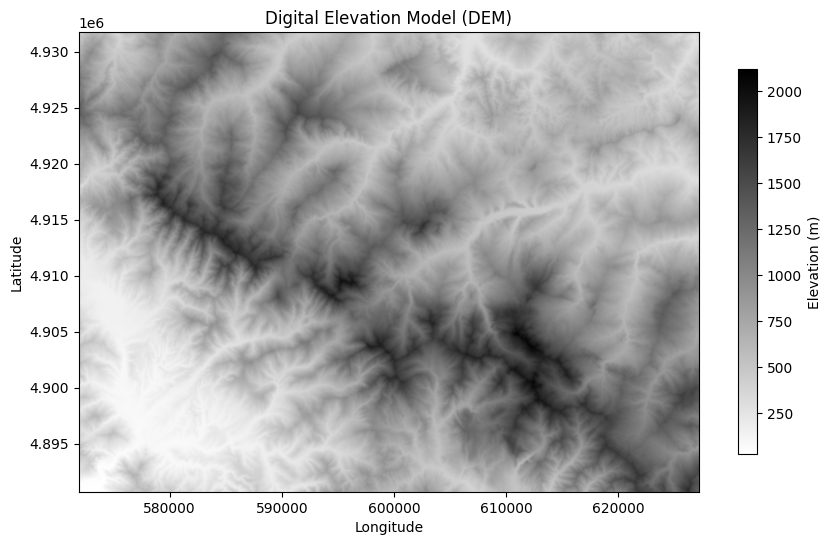

In [15]:
# Open the GeoTIFF file using rasterio
with rasterio.open(dem_path) as src:
    # Read the first band of the dataset
    dem_data = src.read(1)
    
    # Get the spatial extent of the data
    dem_extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    # Plot the data using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(dem_data, cmap='binary', extent=dem_extent)
    plt.colorbar(label='Elevation (m)', shrink=0.5)
    plt.title('Digital Elevation Model (DEM)')
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.show()


Contour Plot

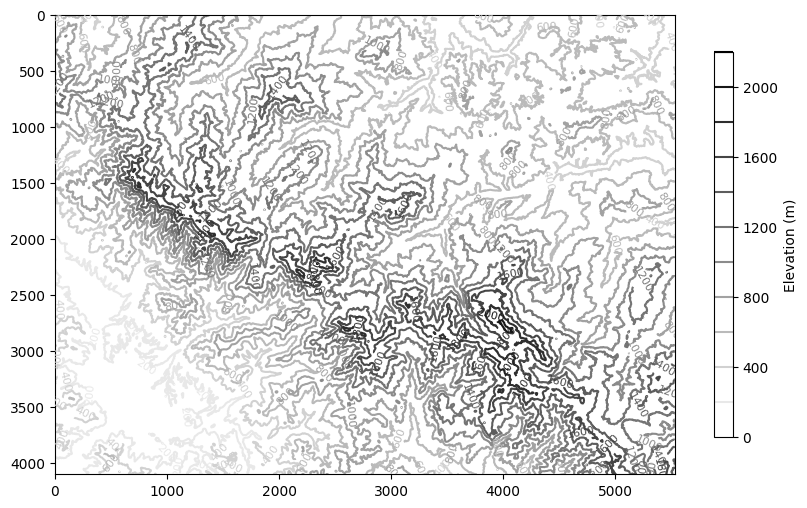

In [18]:
fig = plt.figure(figsize = (10, 10))
contour = plt.contour(dem_data, cmap = "binary", 
            levels = list(range(0, 2400, 200)))
plt.clabel(contour, inline=True, fontsize=8)
# plt.title("Elevation Contours")
# plt.xlabel('lon')
# plt.ylabel('lat')
cbar = plt.colorbar(label='Elevation (m)', shrink=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.show()

Altimetric Areas Plot

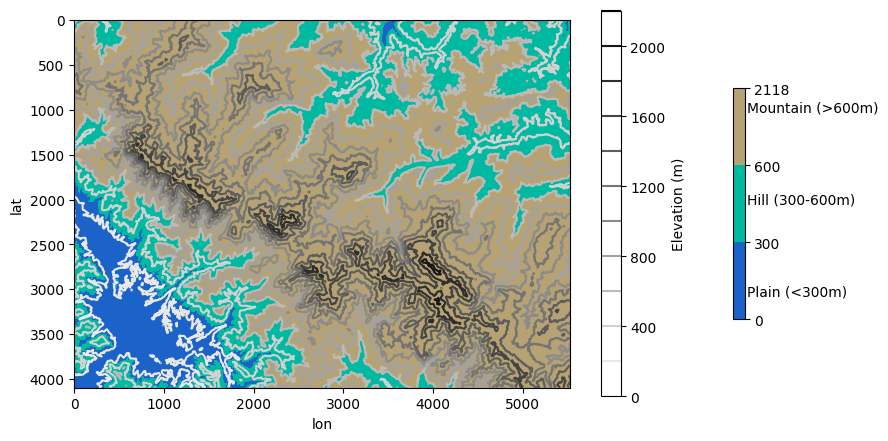

In [51]:
fig = plt.figure(figsize = (10, 10))
contourf = plt.contourf(dem_data, cmap = "terrain", 
            levels = [0, 300, 600, np.max(dem_data)])
cbar = plt.colorbar(shrink=0.3)
cbar.ax.text(1.2, 0.1, 'Plain (<300m)', transform=cbar.ax.transAxes)
cbar.ax.text(1.2, 0.5, 'Hill (300-600m)', transform=cbar.ax.transAxes)
cbar.ax.text(1.2, 0.9, 'Mountain (>600m)', transform=cbar.ax.transAxes)

plt.contour(dem_data, cmap = "binary", 
            levels = list(range(0, 2400, 200)))
plt.clabel(contour, inline=True, fontsize=8)
cbar = plt.colorbar(label='Elevation (m)', shrink=0.5)

# plt.title("Altimetric Areas")
plt.xlabel('lon')
plt.ylabel('lat')

plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.show()

# Download mountain peaks data
From OSM querying Overpass API

In [20]:
# Overpass API query
query = f"""
node["natural"="peak"]({bbox_geo[1]},{bbox_geo[0]},{bbox_geo[3]},{bbox_geo[2]});
"""

# Create an Overpass API instance
api = overpass.API()

response = api.get(query)

# Check correct type of response & not empty
if (response.type == 'FeatureCollection') and (len(response.features) != 0):
    # Save the result to a GeoJSON file
    output_file = 'data/mountain_peaks.geojson'
    with open(output_file, 'w') as f:
        geojson.dump(response, f)

    print(f"Mountain peaks saved to {output_file}")

Mountain peaks saved to data/mountain_peaks.geojson


In [21]:
# Load the mountain peaks GeoJSON file
mountain_peaks_file = 'data/mountain_peaks.geojson'
mountain_peaks = gpd.read_file(mountain_peaks_file)

## Preprocessing mountain peaks 
1. Check CRS
2. Check elevation is numerical
3. Remove peaks without names
4. Peaks with Nan elevation: substitute from DEM
5. Remove peaks on bounds or below 600m.

In [23]:
mountain_peaks.head()

,PDOP,alt_name,description,ele,fixme,importance,loc_name,man_made,name,natural,note,place,source,summit:cross,tourism,wikidata,wikipedia,geometry
0,1.87,None,None,2016,None,regional,None,None,Alpe di Succiso,peak,None,None,survey,None,None,Q1810954,it:Alpe di Succiso,POINT (595311.840 4909530.560)
1,1.16,None,None,1861,None,regional,None,None,Monte Sillara,peak,None,None,survey,None,None,Q3862014,it:Monte Sillara,POINT (584721.210 4913204.321)
2,None,None,None,1717,None,None,None,None,Monte Scala,peak,None,None,CTR 5000 Regione Emilia-Romagna,None,None,None,None,POINT (582994.222 4914845.650)
3,None,None,None,1852,None,regional,None,cross,Monte Marmagna,peak,None,None,None,None,None,Q3861727,it:Monte Marmagna,POINT (579353.120 4916445.071)
4,None,None,None,1797,None,None,None,None,Monte Brusà,peak,None,None,CTR 5000 Regione Emilia-Romagna,None,None,Q3861256,it:Monte Brusa,POINT (581306.101 4915016.808)


In [28]:
len(mountain_peaks)

558

### 1. Check CRS

In [ ]:
# Reproject the mountain peaks
print(f'Peaks CRS: {mountain_peaks.crs}')
print(f'DEM CRS: {dem_crs}')

# The DEM is in EPSG:32632 (meters), while the peaks are in EPSG:4326 (degrees)
# We need to work in meters, so we reproject the peaks to EPSG:32632
if mountain_peaks.crs != dem_crs:
    mountain_peaks = mountain_peaks.to_crs(dem_crs)

### 2. Check column types

In [24]:
# Check column types
mountain_peaks.dtypes

PDOP              object
alt_name          object
description       object
ele               object
fixme             object
importance        object
loc_name          object
man_made          object
name              object
natural           object
note              object
place             object
source            object
summit:cross      object
tourism           object
wikidata          object
wikipedia         object
geometry        geometry
dtype: object

In [25]:
# format elevation column 
mountain_peaks['ele'] = pd.to_numeric(mountain_peaks['ele'], errors='coerce')

### 3. Check NAs

In [26]:
# Check if column has any Nan / None
print(mountain_peaks['name'].isnull().any())
print(mountain_peaks['ele'].isnull().any())

True
True


In [29]:
# How many?
name_nans = mountain_peaks['name'][mountain_peaks['name'].isnull() == True]
ele_nans = mountain_peaks['ele'][mountain_peaks['ele'].isnull() == True]

print(len(name_nans))
print(len(ele_nans))

42
6


In [30]:
# Substitute name with 'alt_name', if present
mountain_peaks['name'] = mountain_peaks['name'].fillna(mountain_peaks['alt_name'])
name_nans = mountain_peaks['name'][mountain_peaks['name'].isnull() == True]
# Remove all remaining peaks with Null names
peaks_clean = mountain_peaks.dropna(subset=['name'])

print(f'Removed no-name peaks: {len(name_nans)}')
peaks_clean['name'].isnull().any() # no Nulls left

Removed no-name peaks: 42


False

In [31]:
# Keep only relevant columns
peaks_clean = peaks_clean[['name', 'ele', 'geometry']]
peaks_clean.head()

,name,ele,geometry
0,Alpe di Succiso,2016.0,POINT (595311.840 4909530.560)
1,Monte Sillara,1861.0,POINT (584721.210 4913204.321)
2,Monte Scala,1717.0,POINT (582994.222 4914845.650)
3,Monte Marmagna,1852.0,POINT (579353.120 4916445.071)
4,Monte Brusà,1797.0,POINT (581306.101 4915016.808)


In [32]:
# Create new elevation column with values from DEM
def extract_elevation(point, dem_data, dem_transform):
    # Transform the point coordinates to the DEM's array indices
    row, col = rasterio.transform.rowcol(dem_transform, point.x, point.y)
    
    # Check if the indices are within the bounds of the DEM array
    if 0 <= row < dem_data.shape[0] and 0 <= col < dem_data.shape[1]:
        # Extract the elevation value at the point
        elevation = round(float(dem_data[row, col]),1)
    else:
        # Handle points outside the DEM bounds (set to NaN or another value)
        elevation = np.nan
    return elevation

# Apply the function to extract elevation and create the 'ele_dem'
peaks_clean['ele_dem'] = peaks_clean['geometry'].apply(lambda point: extract_elevation(point, dem_data, dem_transform))

# Substitute nans in 'ele' with 'ele_dem'
peaks_clean['ele'] = peaks_clean['ele'].fillna(peaks_clean['ele_dem'])

peaks_clean.head(10)

,name,ele,geometry,ele_dem
0,Alpe di Succiso,2016.0,POINT (595311.840 4909530.560),2015.0
1,Monte Sillara,1861.0,POINT (584721.210 4913204.321),1856.0
2,Monte Scala,1717.0,POINT (582994.222 4914845.650),1704.4
3,Monte Marmagna,1852.0,POINT (579353.120 4916445.071),1839.8
4,Monte Brusà,1797.0,POINT (581306.101 4915016.808),1782.0
5,Monte Matto,1838.0,POINT (583072.673 4913890.021),1834.6
6,Monte Paitino,1817.0,POINT (584007.032 4913741.562),1797.0
7,Monte Caio,1575.0,POINT (591428.891 4924466.645),1580.6
8,Monte Tavola,1503.0,POINT (579783.438 4919628.688),1499.8
9,Monte Fosco,1680.0,POINT (579510.938 4918740.723),1676.1


### 4. Remove peaks on bounds or below 600m

In [33]:
# Remove points outside DEM bounds
check_outdem = peaks_clean['ele_dem'][peaks_clean['ele_dem'].isnull() == True]
peaks_clean = peaks_clean.dropna(subset=['ele_dem'])
print(f'Removed peaks outside DEM bounds: {len(check_outdem)}')

Removed peaks outside DEM bounds: 6


In [34]:
# Remove peaks below 600m
below600 = peaks_clean[peaks_clean['ele'] <= 600]
peaks_clean = peaks_clean[peaks_clean['ele'] > 600]

print(f'Removed peaks below 600m: {len(below600)}')

Removed peaks below 600m: 17


In [35]:
# How many peaks are there?
print(f'Total number of peaks: {len(peaks_clean)}')

Total number of peaks: 493


In [36]:
# Save clean dataset as geojson, to be used in analysis part
peaks_clean.to_file('data/peaks_clean.geojson', driver='GeoJSON')

## Data Exploration: mountain peaks

In [37]:
highest_peak = peaks_clean.loc[peaks_clean['ele'].idxmax()]
lowest_peak = peaks_clean.loc[peaks_clean['ele'].idxmin()]
avg_ele = round(peaks_clean['ele'].mean(), 2)

print(f"Highest peak is {highest_peak['name']} ({highest_peak['ele']} m)")
print(f"Lowest peak is {lowest_peak['name']} ({lowest_peak['ele']} m)")
print(f"Average peak elevation: {avg_ele} m")

Highest peak is Monte Cusna (2120.0 m)
Lowest peak is Poggio Tassinara (607.0 m)
Average peak elevation: 1213.76 m


Plot DEM and cleaned peaks

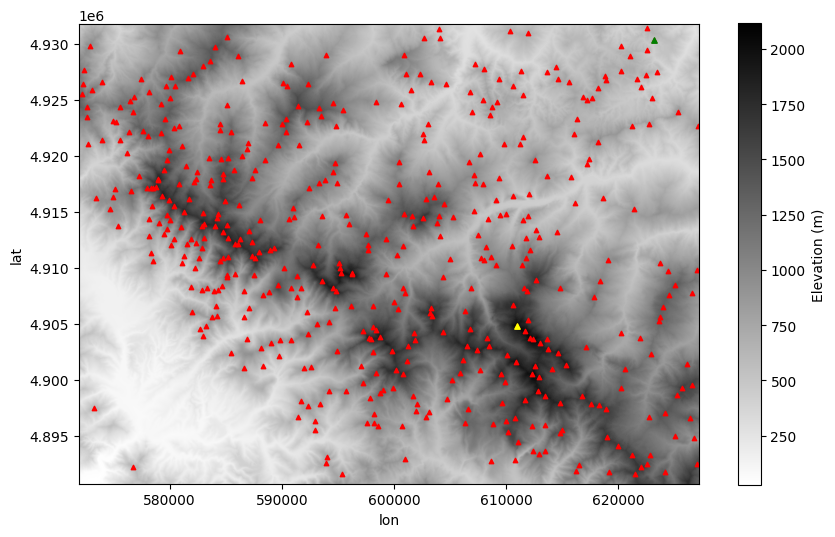

In [67]:
# Plot the DEM
plt.figure(figsize=(10, 6))
plt.imshow(dem_data, cmap='binary', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
plt.colorbar(label='Elevation (m)')

# Plot mountain peaks on top of the DEM
peaks_clean.plot(ax=plt.gca(), color='red', marker='^', markersize=10, label='Mountain Peaks')
plt.scatter(highest_peak.geometry.x, highest_peak.geometry.y, color='yellow', s=15, marker='^', label=f"Highest Peak ({highest_peak['name']}, {highest_peak['ele']} m)")
plt.scatter(lowest_peak.geometry.x, lowest_peak.geometry.y, color='green', s=15, marker='^', label=f"Lowest Peak ({lowest_peak['name']}, {lowest_peak['ele']} m)")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)

# plt.title('Digital Elevation Model (DEM)')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()


Peaks distribution

In [39]:
below1000 = peaks_clean[peaks_clean['ele'] < 1000]
print(f'Peaks between 600-1000m: {len(below1000)}')

above1000 = peaks_clean[(peaks_clean['ele'] >= 1000) & (peaks_clean['ele'] < 2000)]
print(f'Peaks between 1000-2000m: {len(above1000)}')

above2000 = peaks_clean[peaks_clean['ele'] >= 2000]
print(f'Peaks above2000m: {len(above2000)}')
above2000

Peaks between 600-1000m: 170
Peaks between 1000-2000m: 317
Peaks above2000m: 6


,name,ele,geometry,ele_dem
0,Alpe di Succiso,2016.0,POINT (595311.840 4909530.560),2015.0
194,Sasso del Morto,2076.0,POINT (611741.736 4904318.689),2071.1
233,Monte La Piella,2077.0,POINT (612162.762 4903759.578),2071.8
234,Antecima Est Monte La Piella,2070.0,POINT (612429.968 4903603.834),2067.5
453,Monte Cusna,2120.0,POINT (611027.848 4904781.188),2112.3
454,Monte Prado,2054.0,POINT (612371.988 4900528.632),2051.9


In [40]:
pietra = peaks_clean[peaks_clean['name'] == 'Pietra Di Bismantova'] 
pietra

,name,ele,geometry,ele_dem
49,Pietra Di Bismantova,1041.0,POINT (612571.642 4919623.770),1008.3


# Statistical differences between elevations
Comparing elevations from DEM and OSM data: I noticed a difference between the elevation reported from the DEM and OSM data.

In [41]:
peaks_clean['ele_diff'] = peaks_clean['ele'] - peaks_clean['ele_dem']

# Summary statistics
summary_stats = peaks_clean['ele_diff'].describe()
print(summary_stats)

count    493.000000
mean      11.898580
std       24.685635
min     -129.700000
25%        2.500000
50%        7.600000
75%       17.900000
max      281.700000
Name: ele_diff, dtype: float64


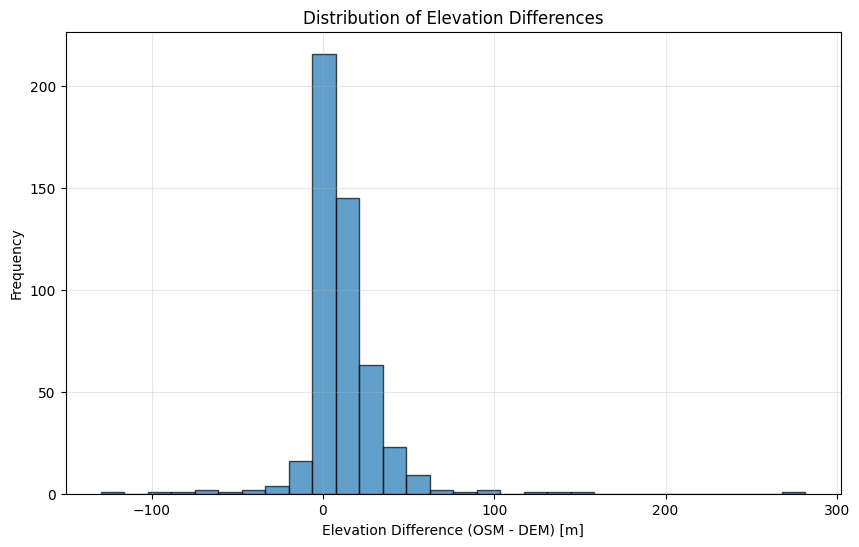

In [42]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(peaks_clean['ele_diff'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Elevation Differences')
plt.xlabel('Elevation Difference (OSM - DEM) [m]')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

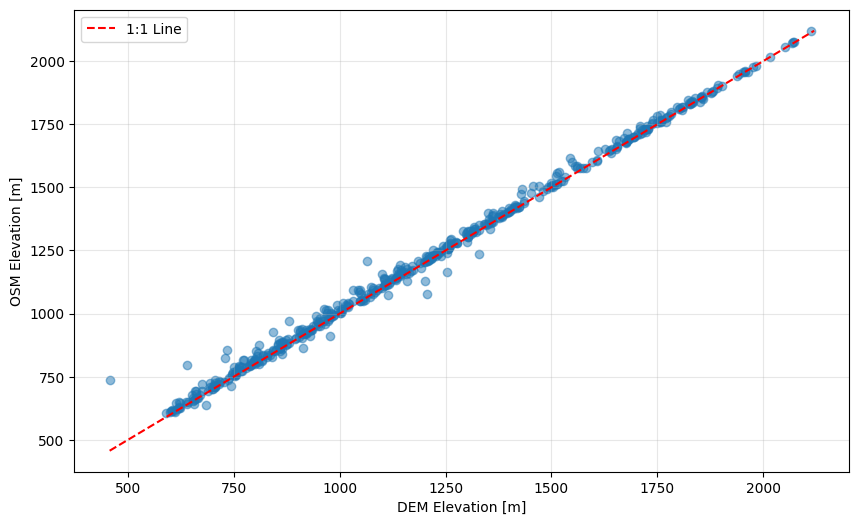

In [68]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(peaks_clean['ele_dem'], peaks_clean['ele'], alpha=0.5)
# 1:1 line
min_ele = min(peaks_clean['ele_dem'].min(), peaks_clean['ele'].min())
max_ele = max(peaks_clean['ele_dem'].max(), peaks_clean['ele'].max())
plt.plot([min_ele, max_ele], [min_ele, max_ele], color='red', linestyle='--', label='1:1 Line')

#plt.title('OSM Elevation vs. DEM Elevation')
plt.xlabel('DEM Elevation [m]')
plt.ylabel('OSM Elevation [m]')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [44]:
# Mean and standard deviation of differences
mean_diff = peaks_clean['ele_diff'].mean()
std_diff = peaks_clean['ele_diff'].std()

print(f"Mean difference: {mean_diff:.2f} m")
print(f"Standard deviation of difference: {std_diff:.2f} m")

Mean difference: 11.90 m
Standard deviation of difference: 24.69 m


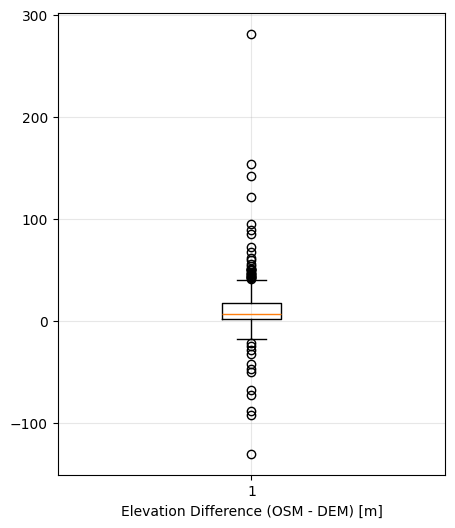

In [69]:
# Box plot
plt.figure(figsize=(5, 6))
plt.boxplot(peaks_clean['ele_diff'].dropna())
#plt.title('Box Plot of Elevation Differences')
plt.xlabel('Elevation Difference (OSM - DEM) [m]')
plt.grid(alpha=0.3)
plt.show()


The mean and std elevation difference changes with respect to the resolution used in the DEM:
- res=100m : mean diff ~45m, standard deviation ~36m
- res=10m (og Tinitaly resolution): mean diff ~12m, standard deviation ~25m

In both cases, from the plots it emerges that the DEM tends to report a slightly lower elevation than OSM data.
I think this difference is not significant, but the choice of the elevation to consider for the analysis is crucial, so this difference should be considered. 